# Ternary Superposition Gate

## Contents
Original qiskit contents (used for calibrating frequency / contruction of $\pi$ pulse) <br>
1. [Getting Started](#importing)
2. [Finding the qubit Frequency using a Frequency Sweep](#frequencysweep)
3. [Calibrating and using a $\pi$ Pulse](#calib)  
--------------------------------------
Addition for our project: <br>
4. [Attempt on Creating a Ternary Superposition Gate](#sgate) <br>
5. [References](#refs)

## 1. Getting Started <a id="importing"></a>

We'll first get our basic dependencies set up and ready to go. Since we want to use real, noisy devices for our calibration experiments in this notebook, we need to load our IBMQ account and set the appropriate backend.

In [1]:
from qiskit.tools.jupyter import *

In [2]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

We verify that the backend supports Pulse features by checking the backend configuration. The config provides us with general information about the structure of the backend setup.

In [3]:
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

For instance, we can find the sampling time for the backend pulses within the backend configuration. This will be a very useful value to us as we build and execute our calibration routines.

In [4]:
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds

Sampling time: 0.2222222222222222 ns


The backend defaults provide a starting point for how to use the backend. It contains estimates for qubit frequencies and default programs to enact basic quantum operators. We can access them with the following:

In [5]:
backend_defaults = backend.defaults()

## 2. Finding the qubit Frequency using a Frequency Sweep <a id="frequencysweep"></a>

We begin by searching for the qubit frequency. The qubit frequency is the difference in energy between the ground and excited states, which we label the $\vert0\rangle$ and $\vert1\rangle$ states, respectively. This frequency will be crucial for creating pulses which enact particular quantum operators on the qubit -- the final goal of our calibration!

With superconducting qubits, higher energy levels are also available, but we fabricate the systems to be anharmonic so that we can control which transition we are exciting. That way, we are able to isolate two energy levels and treat each qubit as a basic two-level system, ignoring higher energy states.

In a typical lab setting, the qubit frequency can be found by sweeping a range of frequencies and looking for signs of absorption using a tool known as a Network Analyzer. This measurement gives a rough estimate of the qubit frequency. Later on, we will see how to do a more precise measurement using a Ramsey pulse sequence.

First, we define the frequency range that will be swept in search of the qubit. Since this can be arbitrarily broad, we restrict ourselves to a window of 40 MHz around the estimated qubit frequency in `backend_defaults`. We step the frequency in units of 1 MHz.

In [6]:
import numpy as np

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-14

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated frequency of 4.971855969373953 GHz.
The sweep will go from 4.951855969373953 GHz to 4.991855969373953 GHz in steps of 1.0 MHz.


Next, we define the pulses we will use for our experiment. We will start with the drive pulse, which is a Gaussian pulse.

Remember the value `dt` from earlier? All durations in pulse are given in terms of `dt`. In the next cell, we define the length of the drive pulse in terms of `dt`.

In [7]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [80]:
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play
# This Pulse module helps us build sampled pulses for common pulse shapes
from qiskit.pulse import library as pulse_lib


# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt
drive_amp = 0.05
# Drive pulse samples
drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                 sigma=drive_sigma,
                                 amp=drive_amp,
                                 name='freq_sweep_excitation_pulse')

In order to properly measure our qubits, we need to check the measurement map. This is a hardware constraint. When acquisition is done for one qubit, it is also done on other qubits. We have to respect this constraint when building our program in Pulse. Let's check which group of qubits our qubit is in:

In [9]:
# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

Now we can define our measurement pulse. Rather than hard coding the pulse, we can obtain a calibrated measurement pulse from the backend default instruction schedule map. Because it is frequently calibrated, it is more accurate than defining a measurement pulse ourselves. This measurement pulse also includes acquisition so we do not need to add that in manually.

In [10]:
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

Lastly, we specify the channels on which we will apply our pulses. Drive, measure, and acquire channels are indexed by qubit index.

In [11]:
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

Now that the pulse parameters have been defined, and we have created the pulse shapes for our experiments, we can proceed to create the pulse schedules.



At each frequency, we will send a drive pulse of that frequency to the qubit and measure immediately after the pulse. The pulse envelopes are independent of frequency, so we will build a reusable `schedule`, and we will specify the drive pulse frequency with a frequency configuration array.

In [12]:
# Create the base schedule
# Start with drive pulse acting on the drive channel
schedule = pulse.Schedule(name='Frequency sweep')
schedule += Play(drive_pulse, drive_chan)
# The left shift `<<` is special syntax meaning to shift the start time of the schedule by some duration
schedule += measure << schedule.duration

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz
schedule_frequencies = [{drive_chan: freq} for freq in frequencies_Hz]

As a sanity check, it's always a good idea to look at the pulse schedule. This is done using `schedule.draw()` as shown below. 

/Users/hyunjinkim/opt/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/qiskit/pulse/schedule.py:1534: DeprecationWarning: Legacy pulse drawer is deprecated. Specified arguments label are deprecated. Please check the API document of new pulse drawer `qiskit.visualization.pulse_drawer_v2`.
  warnings.warn('Legacy pulse drawer is deprecated. '


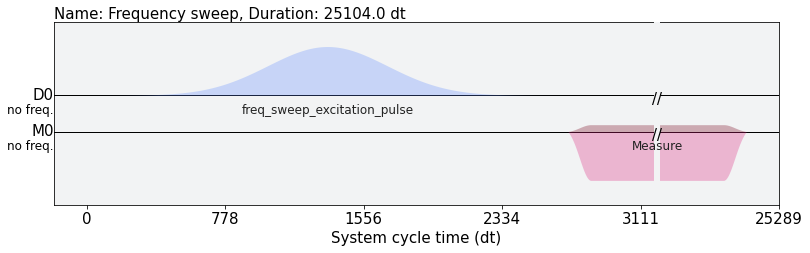

In [13]:
schedule.draw(label=True)

We assemble the `schedules` and `schedule_frequencies` above into a program object, called a Qobj, that can be sent to the quantum device. We request that each schedule (each point in our frequency sweep) is repeated `num_shots_per_frequency` times in order to get a good estimate of the qubit response.

We also specify measurement settings. `meas_level=0` returns raw data (an array of complex values per shot), `meas_level=1` returns kerneled data (one complex value per shot), and `meas_level=2` returns classified data (a 0 or 1 bit per shot). We choose `meas_level=1` to replicate what we would be working with if we were in the lab, and hadn't yet calibrated the discriminator to classify 0s and 1s. We ask for the `'avg'` of the results, rather than each shot individually.

In [14]:
from qiskit import assemble

num_shots_per_frequency = 1024
frequency_sweep_program = assemble(schedule,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

You may see yet another unit change warning, we can safely ignore this. Finally, we can run the assembled program on the backend using:

In [15]:
job = backend.run(frequency_sweep_program)

<ipython-input-15-b1426b634c8f>:1: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(frequency_sweep_program)


It is always a good idea to print the `job_id` for later retrieval, and to monitor the job status by using `job_monitor()`

In [16]:
# print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


Once the job is run, the results can be retrieved using:

In [17]:
frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 120 seconds

We will extract the results and plot them using `matplotlib`:

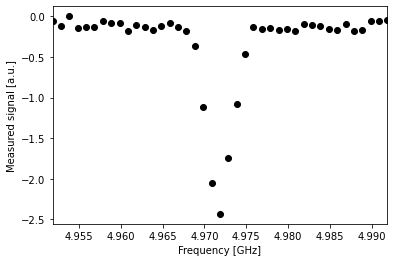

In [18]:
import matplotlib.pyplot as plt

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

As you can see above, the peak near the center corresponds to the location of the qubit frequency. The signal shows power-broadening, which is a signature that we are able to drive the qubit off-resonance as we get close to the center frequency. To get the value of the peak frequency, we will fit the values to a resonance response curve, which is typically a Lorentzian shape.

In [19]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [20]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [-5, 4.975, 1, 5] # initial parameters for curve_fit
                                )

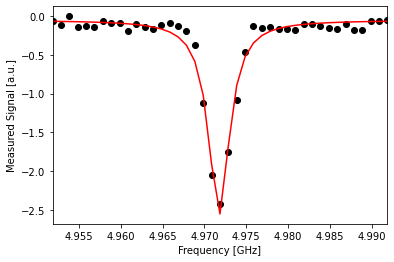

In [21]:
plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [22]:
A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency/GHz, 5)} GHz.")

We've updated our qubit frequency estimate from 4.97186 GHz to 4.97174 GHz.


## 3. Calibrating and using a $\pi$ Pulse <a id="calib"></a>

### Calibrating $\pi$ Pulses using a Rabi Experiment <a id="rabi"></a>

Once we know the frequency of our qubit, the next step is to determine the strength of a $\pi$ pulse. Strictly speaking of the qubit as a two-level system, a $\pi$ pulse is one that takes the qubit from $\vert0\rangle$ to $\vert1\rangle$, and vice versa. This is also called the $X$ or $X180$ gate, or bit-flip operator. We already know the microwave frequency needed to drive this transition from the previous frequency sweep experiment, and we now seek the amplitude needed to achieve a $\pi$ rotation from $\vert0\rangle$ to $\vert1\rangle$. The desired rotation is shown on the Bloch sphere in the figure below -- you can see that the $\pi$ pulse gets its name from the angle it sweeps over on a Bloch sphere.

<img src="https://github.com/aasfaw/qiskit-intros/blob/master/zero_to_one_X180.png?raw=true">


We will change the drive amplitude in small increments and measuring the state of the qubit each time. We expect to see oscillations which are commonly named Rabi oscillations, as the qubit goes from $\vert0\rangle$ to $\vert1\rangle$ and back.

In [23]:
# This experiment uses these values from the previous experiment:
    # `qubit`,
    # `measure`, and
    # `rough_qubit_frequency`.

# Rabi experiment parameters
num_rabi_points = 50

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [24]:
# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.
rabi_schedules = []
for drive_amp in drive_amps:
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, 
                                    sigma=drive_sigma, name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule = pulse.Schedule(name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule += Play(rabi_pulse, drive_chan)
    # Reuse the measure instruction from the frequency sweep experiment
    this_schedule += measure << this_schedule.duration
    rabi_schedules.append(this_schedule)

The schedule will look essentially the same as the frequency sweep experiment. The only difference is that we are running a set of experiments which vary the amplitude of the drive pulse, rather than its modulation frequency.

/Users/hyunjinkim/opt/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/qiskit/pulse/schedule.py:1534: DeprecationWarning: Legacy pulse drawer is deprecated. Specified arguments label are deprecated. Please check the API document of new pulse drawer `qiskit.visualization.pulse_drawer_v2`.
  warnings.warn('Legacy pulse drawer is deprecated. '


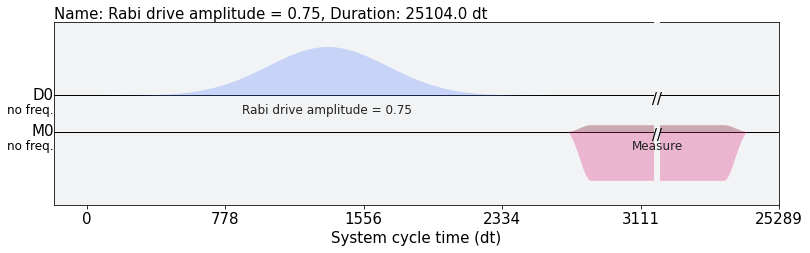

In [25]:
rabi_schedules[-1].draw(label=True)

In [26]:
# Assemble the schedules into a Qobj
num_shots_per_point = 1024

rabi_experiment_program = assemble(rabi_schedules,
                                   backend=backend,
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_point,
                                   schedule_los=[{drive_chan: rough_qubit_frequency}]
                                                * num_rabi_points)

In [27]:
print(job.job_id())
job = backend.run(rabi_experiment_program)
job_monitor(job)

60723cf257095c901f7d82f7


<ipython-input-27-631b1e53aac5>:2: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(rabi_experiment_program)


Job Status: job has successfully run


In [28]:
rabi_results = job.result(timeout=120)

Now that we have our results, we will extract them and fit them to a sinusoidal curve. For the range of drive amplitudes we selected, we expect that we will rotate the qubit several times completely around the Bloch sphere, starting from $|0\rangle$. The amplitude of this sinusoid tells us the fraction of the shots at that Rabi drive amplitude which yielded the $|1\rangle$ state.  We want to find the drive amplitude needed for the signal to oscillate from a maximum (all $|0\rangle$ state) to a minimum (all $|1\rangle$ state) -- this gives the calibrated amplitude that enacts a $\pi$ pulse.

In [29]:
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

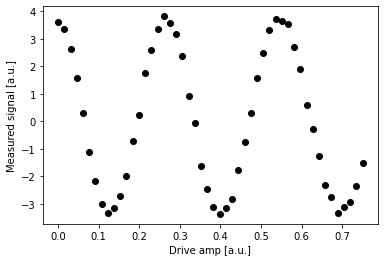

In [30]:
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit]*scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()

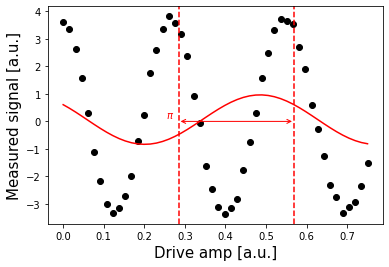

In [31]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [3, 0.1, 0.5, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [32]:
pi_amp = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp}")

Pi Amplitude = 0.28438430261479486


### Our $\pi$ pulse!
Let's define our pulse, with the amplitude we just found, so we can use it in later experiments.

In [33]:
pi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp, 
                              sigma=drive_sigma,
                              name='pi_pulse')

## Attempt on Creating a Ternary Superposition Gate <a id="sgate"></a>

Constructed x90_pulse and used it to transform 0 state to another state between 0 and 1. Then used Rabi experiment to test different amplitudes that might put the qutrit on superposition.

In [47]:
# get x90 pulse using half of pi amplitude
x90_pulse = pulse_lib.gaussian(duration=drive_samples,
                               amp=pi_amp/2, 
                               sigma=drive_sigma,
                               name='x90_pulse')

In [111]:
# s_freq = GHz / (pi_amp)
s_freq = rough_qubit_frequency
# print(s_freq)
# print(rough_qubit_frequency)

4971744383.921157


In [112]:
# Rabi experiment parameters
num_rabi_points = 75

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 1
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [113]:
from qiskit.pulse.library import Waveform

def apply_sideband(pulse, freq):
    """Apply a sinusoidal sideband to this pulse at frequency freq.
    Args:
        pulse (SamplePulse): The pulse of interest.
        freq (float): LO frequency for which we want to apply the sweep.
    Return:
        SamplePulse: Pulse with a sideband applied (oscillates at difference between freq and cal_qubit_freq).
    """
    # time goes from 0 to dt*drive_samples, sine arg of form 2*pi*f*t
    t_samples = np.linspace(0, dt*drive_samples, drive_samples)
    sine_pulse = np.sin(2*np.pi*(freq-rough_qubit_frequency)*t_samples) # no amp for the sine
    
    # create sample pulse w/ sideband applied
    # Note: need to make sq_pulse.samples real, multiply elementwise
    sideband_pulse = Waveform(np.multiply(np.real(pulse.samples), sine_pulse), name='sideband_pulse')
    
    return sideband_pulse 

In [114]:
# Create schedule
rabi_s_schedules = []

# loop over all drive amplitudes
for ii, drive_amp in enumerate(drive_amps):
    base_s_pulse = pulse_lib.gaussian(duration=drive_samples,
                                       sigma=drive_sigma,
                                       amp=drive_amp,
                                       name='base_s_pulse')
    # apply sideband at the 1->2 frequency
    rabi_s_pulse = apply_sideband(base_s_pulse, s_freq)
    
    # add commands to schedule
    schedule2 = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    schedule2 |= pulse.Play(x90_pulse, drive_chan) # 0-> h
    schedule2 |= pulse.Play(rabi_s_pulse, drive_chan) << schedule.duration # h -> s Rabi pulse
    schedule2 |= measure << schedule2.duration # shift measurement to after drive pulse
    
    rabi_s_schedules.append(schedule2)

In [115]:
# Assemble the schedules into a program
rabi_s_expt_program = assemble(rabi_s_schedules,
                                backend=backend,
                                meas_level=1,
                                meas_return='avg',
                                shots=1024,
                                schedule_los=[{drive_chan: s_freq}]
                                               * num_rabi_points)

In [116]:
rabi_s_job = backend.run(rabi_s_expt_program)

<ipython-input-116-5240ce57bb94>:1: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  rabi_s_job = backend.run(rabi_s_expt_program)


In [118]:
print(rabi_s_job.job_id())
job_monitor(rabi_s_job)

6072a274b8a8751c31ee8f39
Job Status: job has successfully run


In [120]:
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data. 
    """
    job_results = job.result(timeout=120) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(job_results.get_memory(i)[qubit]*scale_factor) 
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit]*scale_factor)  
    return result_data

def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require 
    durations which are multiples of 16 samples.
    """
    return (int(num) - (int(num)%16))

In [121]:
# Get the job data (average)
rabi_s_data = get_job_data(rabi_s_job, average=True)

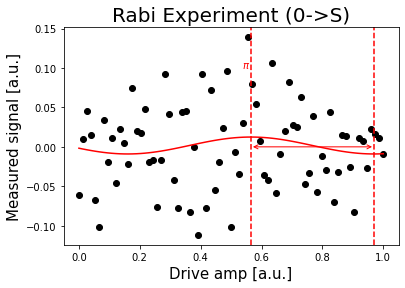

In [154]:
# Note: We only plot the real part of the signal.
rabi_s_data = np.real(baseline_remove(rabi_s_data))
(rabi_s_fit_params, 
 rabi_s_y_fit) = fit_function(drive_amps,
                            rabi_s_data, 
                            lambda x, A, B, drive_s_period, phi: (A*np.cos(2*np.pi*x/drive_s_period - phi) + B),
                            [3, 0.5, 0.9, 0])

plt.scatter(drive_amps, rabi_s_data, color='black')
plt.plot(drive_amps, rabi_s_y_fit, color='red')

drive_s_period = rabi_s_fit_params[2]
# account for phi in computing pi amp
pi_amp_s = (drive_s_period/2/np.pi) *(np.pi+rabi_s_fit_params[3])

plt.axvline(pi_amp_s, color='red', linestyle='--')
plt.axvline(pi_amp_s+drive_s_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_s+drive_s_period/2, 0), xytext=(pi_amp_s,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp_s-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('Rabi Experiment (0->S)', fontsize=20)
plt.show()

In [129]:
print(f"Our updated estimate for the s transition frequency is "
      f"{round(s_freq/GHz, 7)} GHz.")
print(f"Pi Amplitude (1->2) = {pi_amp_s}")

Our updated estimate for the s transition frequency is 4.9717444 GHz.
Pi Amplitude (1->2) = 0.564997162956454


In [128]:
pi_pulse_s = pulse_lib.gaussian(duration=drive_samples,
                                 amp=pi_amp_s, 
                                 sigma=drive_sigma,
                                 name='pi_pulse_s')
# make sure this pulse is sidebanded
pi_pulse_s = apply_sideband(pi_pulse_s, s_freq)

### Implementation of pulse into a quantum circuit as a superposition gate

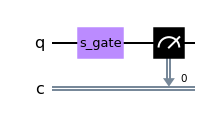

In [56]:
from qiskit import QuantumCircuit
from qiskit.circuit import Gate

circ = QuantumCircuit(1, 1)
s_gate = Gate('s_gate', 1, [])
circ.append(s_gate, [0])
circ.measure(0, 0)

circ.draw('mpl')

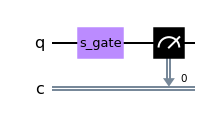

In [155]:
from qiskit import transpile
circ.add_calibration(s_gate, [0], pi_pulse_s)
circ = transpile(circ, backend)
circ.draw('mpl', idle_wires=False)

## References <a id="refs"></a>

1. Team, The Qiskit. Calibrating Qubits with Qiskit Pulse, Data 100 at UC Berkeley, 6 Apr. 2021, qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-pulse.html. 
2. Team, The Qiskit. Accessing Higher Energy States, Data 100 at UC Berkeley, 6 Apr. 2021, qiskit.org/textbook/ch-quantum-hardware/accessing_higher_energy_states.html. 
2. Mandal, Sudhindu Bikash, et al. “Synthesis of Ternary Grover's Algorithm.” 2014 IEEE 44th International Symposium on Multiple-Valued Logic, May 2014, doi:10.1109/ismvl.2014.40. 



In [ ]:
import qiskit
qiskit.__qiskit_version__